In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
import time

# Ejemplo de multiclass

In [2]:
import os.path
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/fnn_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/MNIST_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/draw_nn.py

# MLP in MNIST database of handwritten digits <a class="tocSkip">
- MNIST (Modified National Institute of Standards and Technology database) 
- MPL (Multi-Layer Perceptron)

# Introducción
## Performance de distintos clasificadores 

Ver classifiers:

https://en.wikipedia.org/wiki/MNIST_database

## El MNIST dataset

- Surge de mezclar el NIST original (Test set y Train set eran de fuentes diferentes)
- Mas de 20 años de publicaciones al respecto
- Muy investigado y mucha documentación
- 60.000 imagenes en training y 10.000 en testing
- Todas las imagenes del mismo tamaño 28x28
- Ya preprocesadas
- En su publicación original en 2002 se utilizó SVM (Support Vector Machine) con una exactitud de 0.8

## Video recomendado:
[Tensorflow and deep learning, without a PhD](https://www.youtube.com/watch?v=vq2nnJ4g6N0)

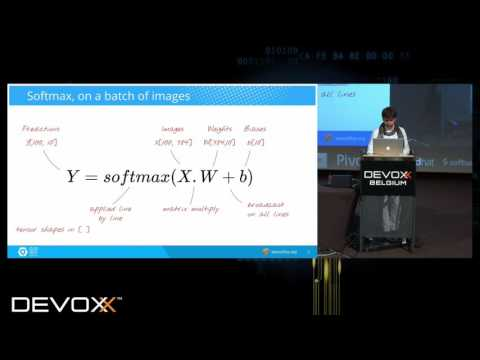

In [3]:
YouTubeVideo('vq2nnJ4g6N0')

# Importar y analizar dataset

In [4]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
from mlp_helper import plot_confusion_matrix
import draw_nn

Using TensorFlow backend.


## Importo el dataset

In [87]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

In [88]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


## Grafico los 100 primeros dígitos

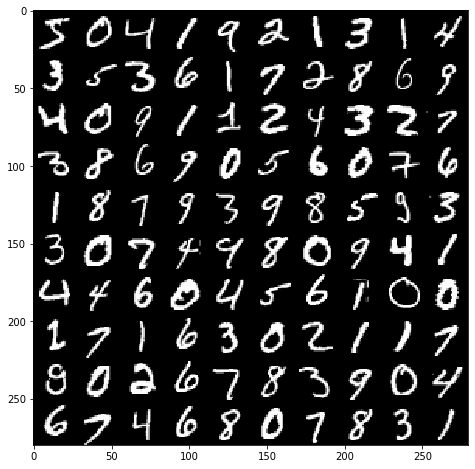

In [89]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

## Vizualizo un dígito en escala de grises

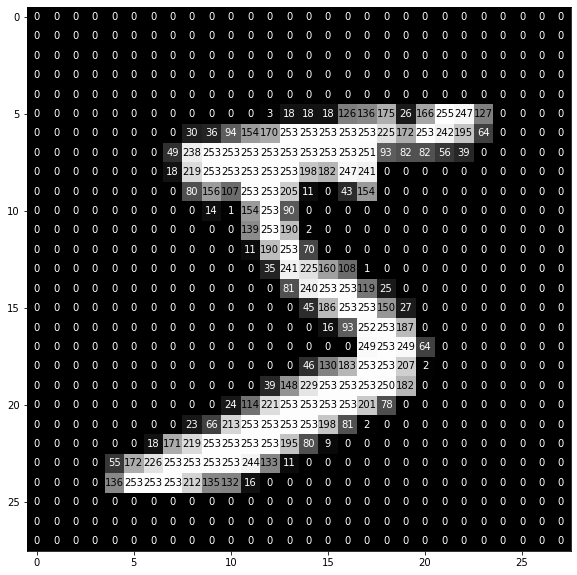

In [90]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[0], ax)
plt.show()

# Normalización

In [91]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

# Regresión logística multinomial

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

## Acomodo entrada

In [93]:
x_train_flattened = x_train.reshape(-1,784)
x_val_flattened = x_val.reshape(-1,784)
x_test_flattened = x_test.reshape(-1,784)

## Entreno clasificador

In [94]:
clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05)
clf_logistic.fit(x_train_flattened, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.05, verbose=0, warm_start=False)

## Imprimo resultados

In [95]:
train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
val_score_logistic = clf_logistic.score(x_val_flattened, y_val)
test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
print(train_score_logistic, val_score_logistic, test_score_logistic)

0.9307291666666667 0.928 0.9261


In [97]:
for C in [0.01, 0.1, 1, 10, 100, 10000]:
    clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05, C=C)
    clf_logistic.fit(x_train_flattened, y_train)
    train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
    val_score_logistic = clf_logistic.score(x_val_flattened, y_val)
    test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
    print(train_score_logistic, val_score_logistic, test_score_logistic)

0.916625 0.91825 0.9185
0.9274375 0.9268333333333333 0.9243
0.9302916666666666 0.9286666666666666 0.9256
0.9303333333333333 0.9283333333333333 0.9259
0.9310416666666667 0.9278333333333333 0.9269
0.93075 0.9286666666666666 0.9257


# Red Neuronal de 1 Capa (Regresión Logística)

## Diagrama

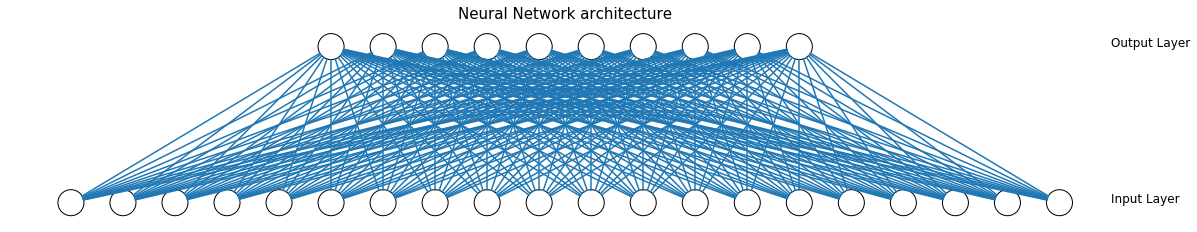

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [98]:
network = draw_nn.DrawNN( [20,10] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

In [99]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K

In [100]:
x_train.shape[1:]

(28, 28)

## Acomodo Salida: one-hot encoding

In [101]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train[i], y_train_categorical[i])


(48000, 10)
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Definimos el modelo

In [102]:
x_train.shape

(48000, 28, 28)

In [132]:
K.clear_session() # Necesario para usar tensorboard para que no de error al correrlo por segunda vez

output_size = 10
# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:])) # Esta capa es opcional, se podria haber hecho el flatten antes
model_single_layer.add(Dense(output_size, kernel_initializer='normal', name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


(784, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


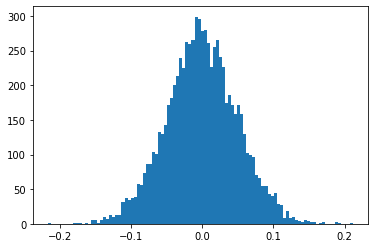

In [133]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)
plt.hist(weights.flatten(), 100)
plt.show()

## Compilamos el modelo
lr suele ser proporcional al mini-bath size. Es decir que si funciona con un lr y aumento el bs, deberia aumentar proporcionalmente el lr

In [134]:
# Compilo el modelo
lr = 0.001
SGD = optimizers.Adam(lr=lr)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

## Preguntas y explicación de parametros

- ¿Por que tiene esa cantidad de parametros?

Capas ([Core Layers](https://keras.io/layers/core/)):
- Dense
- Flatten
- Activation

Parámetros:
- Learning Rate (lr)
- Funciones de activación ([Activations](https://keras.io/activations/)): Sigmoid, Relu, [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- Optimizers: [Keras](https://keras.io/optimizers/), [Articulo interesante](http://ruder.io/optimizing-gradient-descent/)
- Costo ([losses](https://keras.io/losses/))
- [Initializers](https://keras.io/initializers/)

## Exactitud del modelo sin entrenar
**¿Cuanto es de esperar?**

In [135]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.4624473823547364
accuracy:  0.08619999885559082


## Defino Callbacks
(No son estrictamente necesarias)

In [136]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='log_reg.mnist.hdf5', verbose=1, save_best_only=True)
tbCB = TensorBoard(log_dir='./logs_logistic_reg_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=True, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

## Entreno el modelo

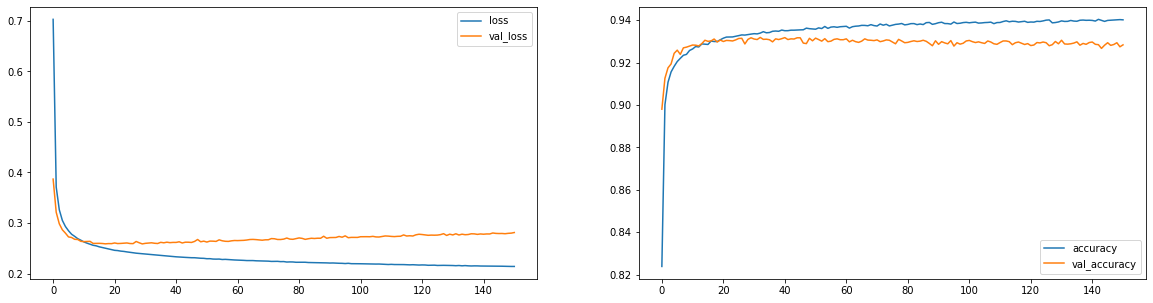


Epoch 00151: val_loss did not improve from 0.25882
Epoch 152/500
48000/48000 [==============================] - 1s 13us/step - loss: 0.2145 - accuracy: 0.9399 - val_loss: 0.2795 - val_accuracy: 0.9293

Epoch 00152: val_loss did not improve from 0.25882
Epoch 153/500
48000/48000 [==============================] - 1s 13us/step - loss: 0.2139 - accuracy: 0.9401 - val_loss: 0.2802 - val_accuracy: 0.9290

Epoch 00153: val_loss did not improve from 0.25882
Epoch 154/500
48000/48000 [==============================] - 1s 13us/step - loss: 0.2140 - accuracy: 0.9393 - val_loss: 0.2794 - val_accuracy: 0.9293

Epoch 00154: val_loss did not improve from 0.25882
Epoch 155/500
48000/48000 [==============================] - 1s 13us/step - loss: 0.2142 - accuracy: 0.9402 - val_loss: 0.2809 - val_accuracy: 0.9289

Epoch 00155: val_loss did not improve from 0.25882
Epoch 156/500
 4800/48000 [==>...........................] - ETA: 0s - loss: 0.2089 - accuracy: 0.9379

KeyboardInterrupt: 

In [137]:
batch_size = 1000
batch_size = 100
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

**¿Por que val_loss y val_acc es menos ruidosa que loss y val?**

## Exactitud del modelo despues de entrenar

In [138]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.29428369215875866
accuracy:  0.9251000285148621


## Cargo pesos guardados
Los pesos fueron guardados con la clase ModelCheckpoint. Vamos a recuperarlos

In [139]:
model_single_layer.load_weights('log_reg.mnist.hdf5')

In [140]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.26585327248573304
accuracy:  0.9275000095367432


In [141]:
score = model_single_layer.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.25882273582617443
accuracy:  0.9316666722297668


In [142]:
score = model_single_layer.evaluate(x_train, y_train_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.2347388550415635
accuracy:  0.934541642665863


## Analisis de los pesos

(784, 10)
[-0.4992741   0.81936496  0.11768138 -0.46983564  0.18274143  1.5741683
 -0.25908512  0.87023836 -1.7347221  -0.41760856]


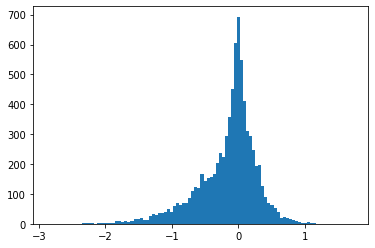

In [143]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)
plt.hist(weights.flatten(), 100)
plt.show()

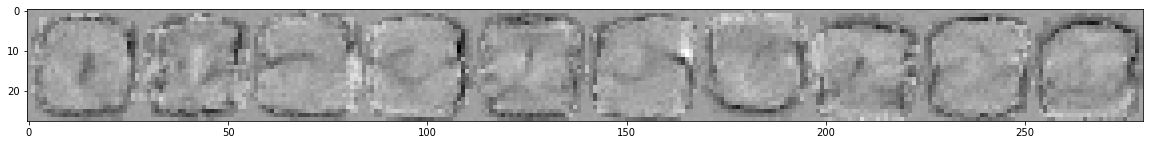

In [144]:
plt.figure(figsize=(20,20))
concatenated_weights = weights[:,0].reshape(28,28)
for wei in weights.T[1:10]:
    concatenated_weights = np.concatenate((concatenated_weights, wei.reshape(28,28)),axis=1 )
plt.imshow(concatenated_weights, cmap='gray')
plt.show()

## Analisis de dígitos errados

In [145]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [146]:
def get_sorted_errors(model):
    losses = []
    for i in range(len(x_test)):
        CE_loss = model.evaluate(x_test[i:i+1], y_test_categorical[i:i+1], verbose=0)[0]
        losses.append(CE_loss)
    predictions = model.predict(x_test)
    predicted_numbers = predictions.argmax(axis=1)
    sorted_loss_indexes = np.argsort(losses)[::-1]
    return predictions, predicted_numbers, sorted_loss_indexes

In [147]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model_single_layer)
print(predictions[:2])
print(predicted_numbers[:2])

[[4.6048717e-07 7.2715987e-13 1.2002878e-06 5.0977780e-03 1.9279567e-07
  1.8809067e-05 1.1452624e-12 9.9442577e-01 1.3311956e-05 4.4253658e-04]
 [2.8438053e-05 1.0204732e-05 9.9689072e-01 1.1777362e-05 2.9210058e-16
  2.3621334e-04 2.8087597e-03 2.9977962e-20 1.3918290e-05 1.5379589e-16]]
[7 2]


In [148]:
from collections import Counter

In [149]:
errors_dict = Counter(list(zip(y_test[sorted_loss_indexes], predicted_numbers[sorted_loss_indexes])))

In [150]:
print(errors_dict.most_common()[10:])

[((7, 9), 40), ((2, 8), 39), ((4, 9), 37), ((5, 3), 35), ((5, 8), 33), ((7, 2), 24), ((8, 5), 22), ((3, 5), 22), ((3, 8), 21), ((8, 3), 21), ((3, 2), 18), ((9, 4), 17), ((5, 6), 15), ((2, 3), 15), ((9, 7), 15), ((2, 6), 12), ((6, 5), 12), ((6, 0), 12), ((9, 0), 11), ((2, 1), 11), ((8, 9), 11), ((1, 8), 11), ((3, 9), 10), ((3, 7), 10), ((2, 7), 9), ((9, 3), 9), ((4, 8), 9), ((8, 6), 9), ((4, 6), 9), ((6, 2), 9), ((5, 7), 9), ((5, 0), 8), ((7, 3), 8), ((8, 2), 8), ((9, 1), 8), ((8, 4), 7), ((8, 0), 7), ((8, 7), 7), ((5, 9), 7), ((5, 4), 7), ((6, 4), 7), ((2, 4), 6), ((7, 1), 6), ((0, 5), 6), ((4, 2), 6), ((2, 0), 6), ((9, 8), 6), ((0, 6), 6), ((8, 1), 6), ((7, 4), 6), ((9, 5), 5), ((5, 2), 4), ((4, 7), 4), ((2, 9), 3), ((1, 2), 3), ((6, 1), 3), ((1, 6), 3), ((2, 5), 3), ((3, 0), 3), ((1, 3), 2), ((3, 6), 2), ((0, 7), 2), ((0, 3), 2), ((7, 8), 2), ((5, 1), 2), ((4, 3), 2), ((4, 1), 2), ((6, 8), 2), ((1, 7), 2), ((1, 5), 1), ((4, 0), 1), ((7, 0), 1), ((0, 8), 1), ((0, 9), 1), ((9, 2), 1), 

[(2, 9), (1, 5), (4, 0), (1, 3), (9, 0), (7, 2), (1, 2), (2, 6), (2, 4), (2, 7), (2, 4), (7, 2), (3, 9), (2, 4), (8, 4), (3, 8), (9, 0), (7, 1), (5, 8), (5, 6), (7, 2), (3, 6), (0, 7), (9, 0), (9, 3), (0, 3), (2, 6), (2, 7), (7, 1), (5, 8), (0, 5), (2, 8), (5, 0), (4, 2), (6, 5), (7, 8), (7, 2), (5, 6), (2, 8), (7, 2), (5, 6), (9, 0), (7, 2), (9, 4), (2, 8), (6, 1), (7, 3), (4, 2), (2, 4), (7, 3), (7, 2), (8, 0), (5, 6), (8, 7), (6, 0), (5, 3), (4, 8), (2, 8), (9, 3), (2, 6), (8, 5), (8, 3), (2, 0), (5, 9), (8, 4), (2, 1), (7, 1), (5, 0), (3, 7), (8, 9), (2, 3), (9, 0), (9, 8), (0, 6), (7, 9), (5, 1), (8, 4), (7, 2), (6, 5), (6, 0), (2, 3), (2, 6), (2, 7), (5, 2), (7, 9), (5, 4), (8, 3), (3, 8), (9, 3), (4, 2), (1, 2), (5, 3), (8, 6), (5, 6), (3, 8), (4, 2), (6, 0), (2, 9), (4, 9), (7, 9)]


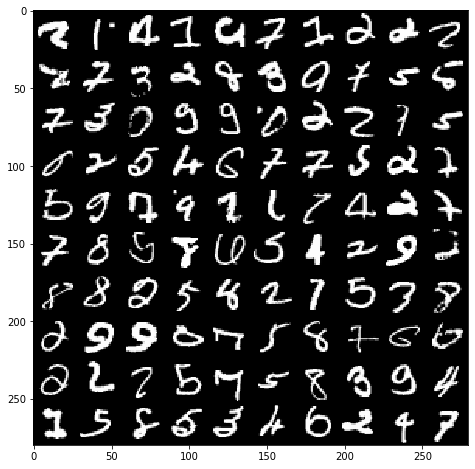

In [151]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

In [152]:
np.argmax(predictions, axis=1), y_test

(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

Confusion matrix, without normalization


[]

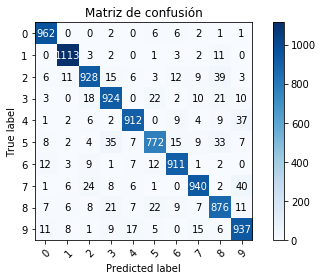

In [153]:
plot_confusion_matrix(y_test, np.argmax(predictions, axis=1), [i for i in range(10)], title="Matriz de confusión")
plt.plot()

# Red Neuronal de 2 capas (Una capa Oculta)

## Diagrama

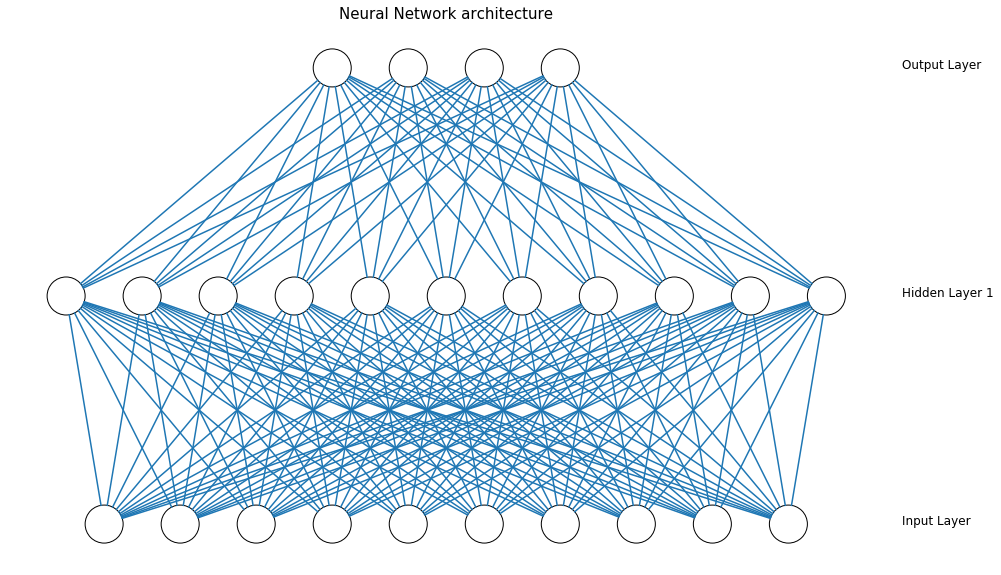

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [154]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

## Definición y compilación del modelo

In [155]:
from keras.callbacks import ReduceLROnPlateau

In [176]:
K.clear_session()
def two_layer_model(lr=0.001, decay=0, hidden_units=800, activation='relu'):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units, activation=activation, kernel_initializer='normal', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    Adam = optimizers.Adam(lr=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_two_layers = two_layer_model()
model_two_layers.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


## Calculo de la cantidad de parámetros
**¿de donde sale la cantidad de parámetros?**

In [177]:
first_layer = 784*800+800
print(first_layer)
last_layer = 800*10 + 10
print(last_layer)
print(first_layer+last_layer)

628000
8010
636010


## Evaluación antes de entrenar

In [178]:
score_two_layers = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])

loss:  2.3397972465515138
accuracy:  0.1387999951839447


## Entrenamientos

### Learning rate = 0.01

In [194]:
tbCB2 = TensorBoard(log_dir='./logs_one-hidden_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=False, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='one-hidden.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')

rop = ReduceLROnPlateau(monitor='val_accuracy', min_delta=0.0001, verbose=1)

model_two_layers = two_layer_model(lr=0.0001, hidden_units=10_000, decay=1e-8, activation='relu') # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=256, 
          #verbose=1, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[checkpointer]) #plot_losses, tbCB2, rop

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s 34us/step - loss: 0.3910 - accuracy: 0.8837 - val_loss: 0.1865 - val_accuracy: 0.9474

Epoch 00001: val_accuracy improved from -inf to 0.94742, saving model to one-hidden.mnist.hdf5
Epoch 2/200
48000/48000 [==============================] - 1s 27us/step - loss: 0.1534 - accuracy: 0.9574 - val_loss: 0.1442 - val_accuracy: 0.9606

Epoch 00002: val_accuracy improved from 0.94742 to 0.96058, saving model to one-hidden.mnist.hdf5
Epoch 3/200
48000/48000 [==============================] - 2s 32us/step - loss: 0.1056 - accuracy: 0.9715 - val_loss: 0.1187 - val_accuracy: 0.9664

Epoch 00003: val_accuracy improved from 0.96058 to 0.96642, saving model to one-hidden.mnist.hdf5
Epoch 4/200
48000/48000 [==============================] - 2s 32us/step - loss: 0.0791 - accuracy: 0.9798 - val_loss: 0.1089 - val_accuracy: 0.9696

Epoch 00004: val_accuracy improved from 0.96642 to 0.96958, sav

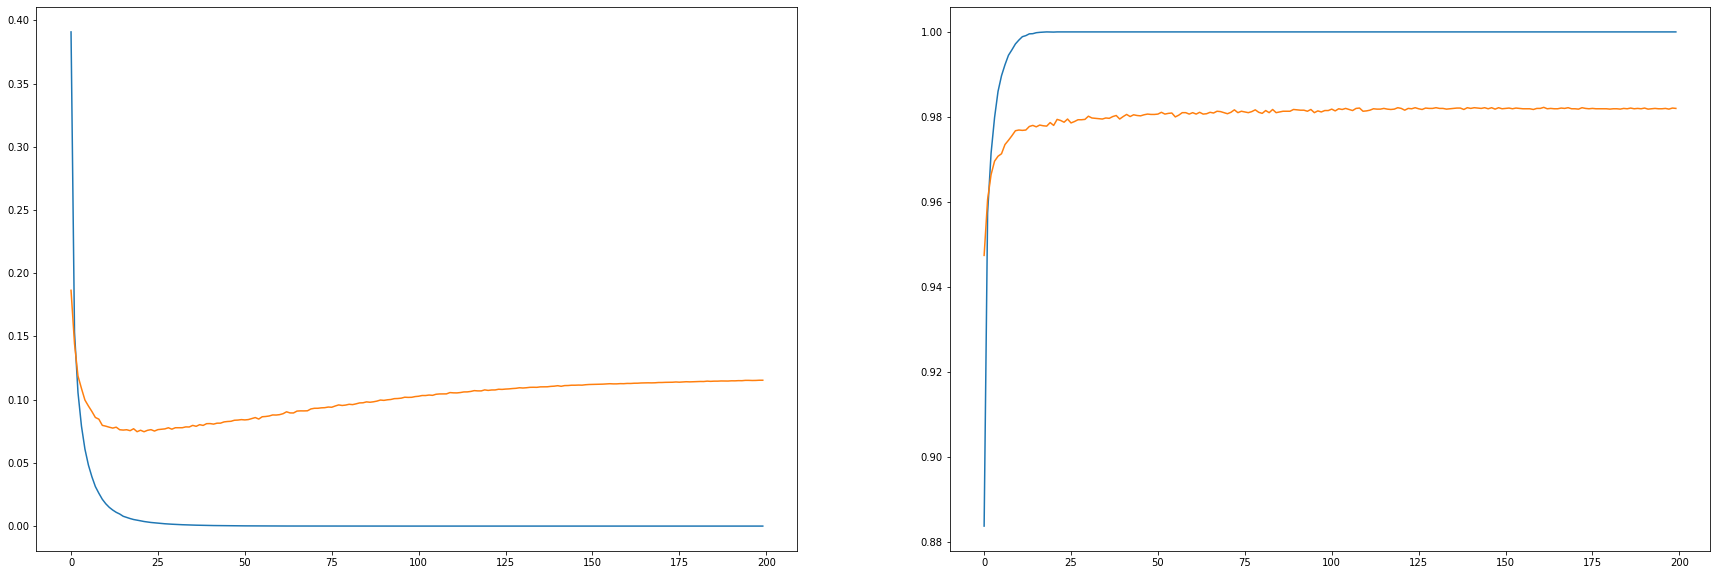

In [195]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_two_layers.history.history['loss'])
ax1.plot(model_two_layers.history.history['val_loss'])
ax2.plot(model_two_layers.history.history['accuracy'])
ax2.plot(model_two_layers.history.history['val_accuracy'])

In [197]:
from sklearn.metrics import roc_auc_score
# roc_auc_score(y_true, y_score, average='macro',  multi_class='ovr')

In [196]:
model_two_layers.save_weights('one-hidden_last.mnist.hdf5')

In [200]:
(CE_train, acc_train) = model_two_layers.evaluate(x_train, y_train_categorical, verbose=0)
print(CE_train, acc_train)

2.2202121440765648e-07 1.0


In [201]:
(CE_test, acc_test) = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print(CE_test, acc_test)

0.10273236494570658 0.9825999736785889


In [212]:
import sklearn

In [213]:
sklearn.__version__

'0.20.1'

In [211]:
predictions_test = model_two_layers.predict(x_test)
print(predictions_test.shape)
print(y_test_categorical.shape)
roc_auc_score(x_test, y_test)

(10000, 10)
(10000, 10)


ValueError: unknown format is not supported

In [ ]:
model_two_layers.load_weights('one-hidden.mnist.hdf5')

In [191]:

model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 26us/step


[0.09393720179050563, 0.9829000234603882]

(784, 800)
(800,)


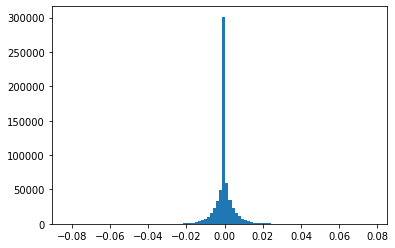

In [111]:
weights = model_two_layers.get_weights()[0]
biases = model_two_layers.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

Confusion matrix, without normalization


[]

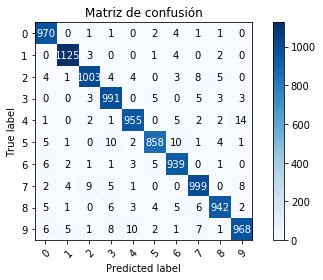

In [114]:
preds_two_layers = model_two_layers.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(preds_two_layers, axis=1), [i for i in range(10)], title='Matriz de confusión')
plt.plot()

# Red Neuronal de 5 capas (4 ocultas)

## Activation: Relus
### Definición y compilación del modelo

In [41]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
K.clear_session()
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [42]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='four-hidden.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')

tbCB3 = TensorBoard(log_dir='./logs_four-hidden_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=True, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

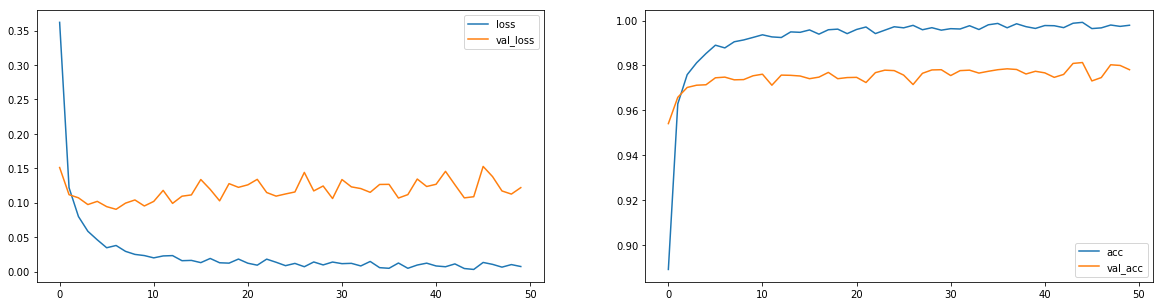


Epoch 00050: val_acc did not improve from 0.98130


In [398]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=256, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer, tbCB3],
         )

In [399]:
model.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 14us/step


[0.006906139062375739, 0.9983541666666667]

In [400]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 16us/step


[0.12195321380897357, 0.9781]

In [43]:
model.load_weights('five-layer.mnist.hdf5')

In [44]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 17us/step


[0.1381119653036276, 0.982]

(784, 200)
(200,)


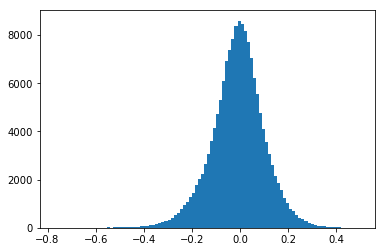

In [45]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

### Resultados

In [46]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model)

[(4, 8), (4, 6), (9, 1), (7, 2), (2, 4), (5, 0), (7, 2), (4, 6), (9, 1), (5, 8), (8, 7), (4, 6), (3, 9), (6, 4), (6, 1), (2, 8), (2, 0), (2, 7), (9, 8), (5, 6), (3, 7), (3, 2), (9, 4), (8, 4), (2, 7), (4, 9), (5, 3), (2, 8), (3, 8), (4, 9), (6, 3), (4, 9), (7, 3), (6, 4), (7, 2), (4, 9), (8, 2), (9, 3), (5, 4), (1, 6), (4, 2), (2, 8), (6, 5), (1, 2), (5, 3), (3, 9), (4, 7), (2, 8), (6, 0), (2, 4), (2, 0), (5, 6), (9, 5), (8, 5), (8, 0), (7, 1), (3, 5), (2, 3), (3, 7), (0, 6), (4, 7), (0, 6), (8, 9), (8, 4), (7, 1), (0, 1), (5, 3), (4, 6), (9, 5), (0, 9), (8, 3), (0, 8), (6, 5), (9, 0), (8, 0), (6, 5), (8, 9), (7, 1), (7, 1), (9, 5), (5, 3), (8, 9), (9, 3), (4, 8), (2, 3), (7, 0), (7, 2), (8, 3), (5, 9), (2, 7), (2, 8), (8, 5), (3, 9), (7, 4), (3, 8), (6, 1), (3, 5), (7, 2), (8, 7), (8, 5)]


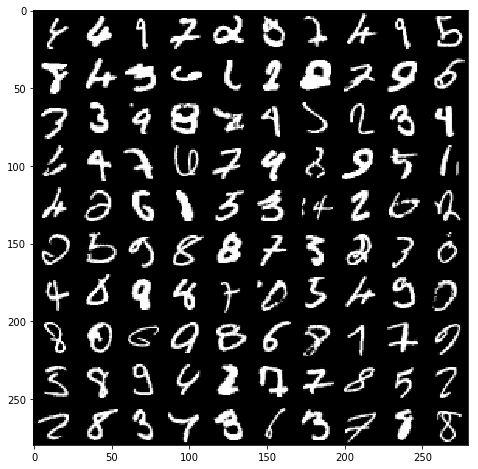

In [47]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

Confusion matrix, without normalization


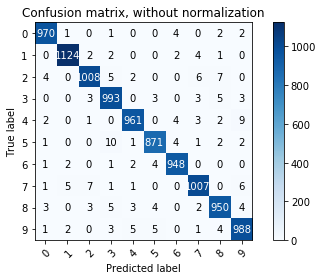

In [48]:
preds_last = model.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(preds_last, axis=1), [i for i in range(10)])

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros
- Se pierden las relaciones originales de los pixeles adyacentes (flatten). 